In [1]:
import pandas, numpy
import os
from IPython.display import display, HTML
import datetime, calendar
from plotly import express
import plotly.graph_objects as go
import matplotlib.pyplot as pltmp, seaborn as sbtmp
from sklearn import neighbors, ensemble,linear_model, neural_network, tree, svm
from sklearn import metrics, decomposition, model_selection, pipeline,preprocessing, feature_selection,utils
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

import matplotlib, pickle
mtvl=[20,14,14,'#2554C7']
mt_ft=['axes.labelsize','xtick.labelsize','ytick.labelsize','text.color']
for f in range(len(mtvl)):
    matplotlib.rcParams[mt_ft[f]]=mtvl[f]
font = {'family' : 'serif',
        'size'   : 18}
matplotlib.rc('font', **font)

In [17]:
TmpChgDf=pandas.read_csv("FAOSTAT_data_en_11-1-2024.csv")
display(HTML(TmpChgDf.head().to_html()))

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Months Code,Months,Year Code,Year,Unit,Value,Flag,Flag Description
0,ET,Temperature change on land,4,Afghanistan,7271,Temperature change,7001,January,1961,1961,°c,0.745,E,Estimated value
1,ET,Temperature change on land,4,Afghanistan,7271,Temperature change,7001,January,1962,1962,°c,0.015,E,Estimated value
2,ET,Temperature change on land,4,Afghanistan,7271,Temperature change,7001,January,1963,1963,°c,2.706,E,Estimated value
3,ET,Temperature change on land,4,Afghanistan,7271,Temperature change,7001,January,1964,1964,°c,-5.250,E,Estimated value
4,ET,Temperature change on land,4,Afghanistan,7271,Temperature change,7001,January,1965,1965,°c,1.854,E,Estimated value


In [18]:
EngCountries=['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'CzechRepublic', 'Denmark', 
              'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 
              'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'theNetherlands', 'Poland', 
              'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'United Kingdom of Great Britain and Northern Ireland']
MnthsData=['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December']
TmpChgDf=TmpChgDf.loc[TmpChgDf['Area'].isin(EngCountries)].reset_index(drop=True)
TmpChgDf=TmpChgDf.loc[TmpChgDf['Months'].isin(MnthsData)].reset_index(drop=True)
TmpChgDf

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Months Code,Months,Year Code,Year,Unit,Value,Flag,Flag Description
0,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,January,1961,1961,°c,-0.807,E,Estimated value
1,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,January,1962,1962,°c,1.345,E,Estimated value
2,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,January,1963,1963,°c,-5.065,E,Estimated value
3,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,January,1964,1964,°c,-3.162,E,Estimated value
4,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,January,1965,1965,°c,1.431,E,Estimated value
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16471,ET,Temperature change on land,826,United Kingdom of Great Britain and Northern I...,7271,Temperature change,7012,December,2019,2019,°c,1.285,E,Estimated value
16472,ET,Temperature change on land,826,United Kingdom of Great Britain and Northern I...,7271,Temperature change,7012,December,2020,2020,°c,0.652,E,Estimated value
16473,ET,Temperature change on land,826,United Kingdom of Great Britain and Northern I...,7271,Temperature change,7012,December,2021,2021,°c,1.428,E,Estimated value
16474,ET,Temperature change on land,826,United Kingdom of Great Britain and Northern I...,7271,Temperature change,7012,December,2022,2022,°c,-0.688,E,Estimated value


In [19]:
def TcnClean(tcn):
    print("==========================================")
    print("      Data Infomation")
    print("==========================================")
    print(tcn.info())
    print("===================================================")
    print("Missing Values Before Cleaning")
    print("===================================================")
    print(tcn.isnull().sum())
    tcnmsv=sum(tcn.isnull().sum())
    if tcnmsv>0:
        covob=tcn.dtypes[tcn.dtypes=='object'].index.tolist()
        covnm=tcn.dtypes[tcn.dtypes!='object'].index.tolist() 
        if sum(tcn.isna().sum())!=0:
            for x in covob:
                tcn[x]=tcn[x].fillna(tcn[x].mode()[0])
            for y in covnm:
                tcn[y]=tcn[y].fillna(tcn[y].mean())
        print("===================================================")
        print("      Missing Values (After Cleaning)")
        print("===================================================")
        print(tcn.isnull().sum())
    else:
        print("===================================================")
        print("      Data has no Missing Values ")
        print("===================================================")
    return tcn
TmpChgDfMS=TcnClean(TmpChgDf)

      Data Infomation
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16476 entries, 0 to 16475
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Domain Code       16476 non-null  object 
 1   Domain            16476 non-null  object 
 2   Area Code (M49)   16476 non-null  int64  
 3   Area              16476 non-null  object 
 4   Element Code      16476 non-null  int64  
 5   Element           16476 non-null  object 
 6   Months Code       16476 non-null  int64  
 7   Months            16476 non-null  object 
 8   Year Code         16476 non-null  int64  
 9   Year              16476 non-null  int64  
 10  Unit              16476 non-null  object 
 11  Value             16476 non-null  float64
 12  Flag              16476 non-null  object 
 13  Flag Description  16476 non-null  object 
dtypes: float64(1), int64(5), object(8)
memory usage: 1.8+ MB
None
Missing Values Before Cleaning
Domain Code        

## Data Analytics

         Area     Value
0  Luxembourg  1.620576
1     Belgium  1.563750
2     Estonia  1.551352
3    Slovenia  1.535167
4      Latvia  1.525042
5   Lithuania  1.482896
6     Croatia  1.382987
7    Slovakia  1.273586
8     Austria  0.848000
9     Finland  0.810856


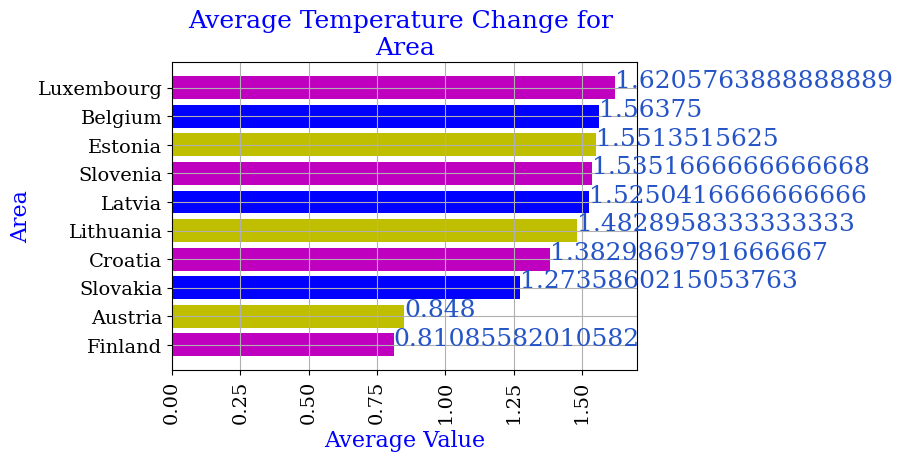

      Months     Value
0    January  0.987692
1      March  0.975591
2     August  0.974635
3   February  0.971387
4       July  0.965931
5      April  0.843393
6        May  0.791655
7       June  0.740615
8    October  0.636482
9  September  0.594165


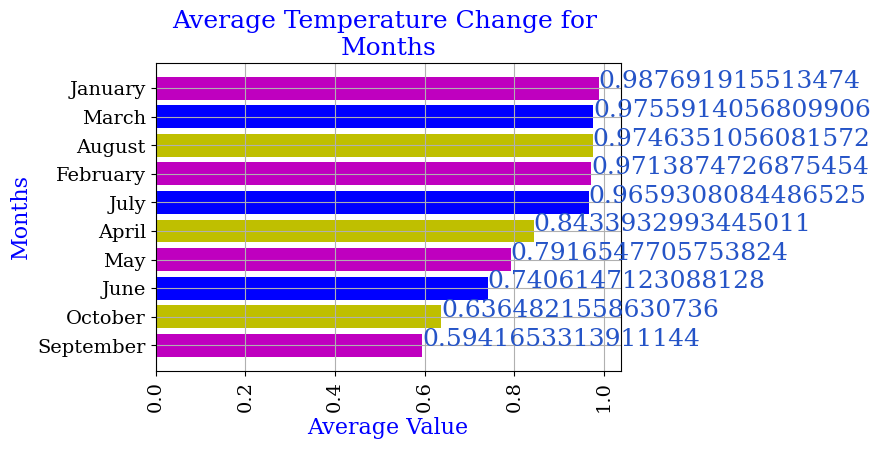

In [20]:
def VisualData(tcn,c1,c2):
    df=tcn.groupby(["{}".format(c1)]).agg({"{}".format(c2): [numpy.mean]}).sort_values(by=("{}".format(c2),"mean"),ascending=False).iloc[:10]
    fet=df.index.tolist()
    val=df.values.flatten()
    df1=pandas.DataFrame({
        "{}".format(c1):fet,
        "{}".format(c2):val
    })
    print(df1)
    df1=df1.sort_values(by="{}".format(c2),ascending=True)
    pltmp.figure(figsize=(6,4))
    pltmp.title("Average Temperature Change for \n{}".format(c1),fontsize=18,color="b")
    pltmp.barh(df1["{}".format(c1)],df1["{}".format(c2)],color=["m","y","b"])
    pltmp.xticks(rotation=90)
    pltmp.xlabel("Average {}".format(c2),fontsize=16,color="b")
    pltmp.ylabel("{}".format(c1),fontsize=16,color="b")
    for df1_id, df1_val in enumerate(df1["{}".format(c2)]):
        pltmp.text(df1_val, df1_id, str(df1_val))
    pltmp.grid()
    pltmp.show()
VisualData(TmpChgDf,"Area","Value")
VisualData(TmpChgDf,"Months","Value")

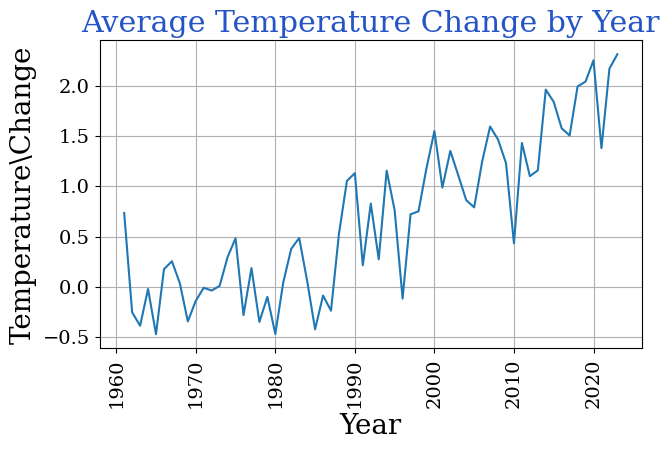

,Average Temperature Change
Year,
1961,0.734241
1962,-0.254181
1963,-0.387639
1964,-0.021819
1965,-0.471796
...,...
2019,2.040888
2020,2.252763
2021,1.378728


In [21]:
YrUn=TmpChgDf['Year'].unique()
YrTmmn=[]
for yr in YrUn:
    yrdf=TmpChgDf[TmpChgDf['Year Code']==yr].reset_index(drop=True)
    YrTmmn.append(yrdf['Value'].mean())
YrMnDf=pandas.DataFrame({
    "Year":YrUn,
    "Average Temperature Change":YrTmmn
})
YrMnDf=YrMnDf.set_index('Year')
pltmp.figure(figsize=(7,4))
pltmp.plot(YrMnDf.index,YrMnDf["Average Temperature Change"])
pltmp.title("Average Temperature Change by Year")
pltmp.xlabel("Year")
pltmp.ylabel("Temperature\Change")
pltmp.xticks(rotation=90)
pltmp.grid()
pltmp.show()
YrMnDf

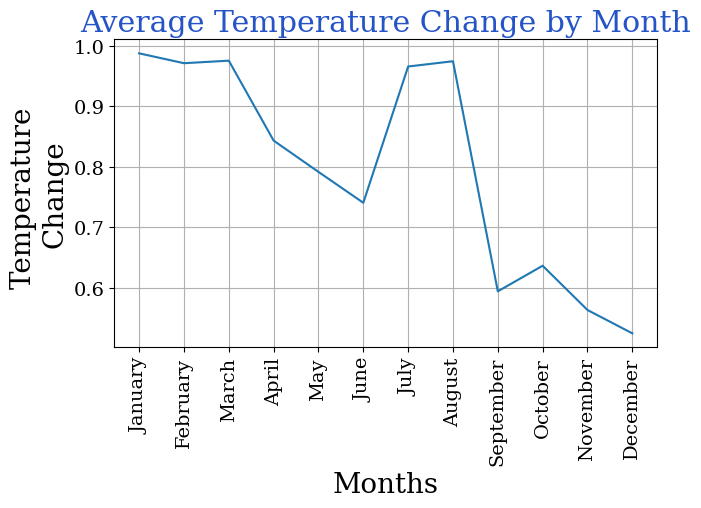

,Average Temperature Change
Month,
January,0.987692
February,0.971387
March,0.975591
April,0.843393
May,0.791655
June,0.740615
July,0.965931
August,0.974635
September,0.594165


In [22]:
MnUn=TmpChgDf['Months'].unique()[:12]
MnTmmn=[]
for Mn in MnUn:
    Mndf=TmpChgDf[TmpChgDf['Months']==Mn].reset_index(drop=True)
    MnTmmn.append(Mndf['Value'].mean())
MnMnDf=pandas.DataFrame({
    "Month":MnUn,
    "Average Temperature Change":MnTmmn
})
MnMnDf=MnMnDf.set_index('Month')
pltmp.figure(figsize=(7,4))
pltmp.plot(MnMnDf.index,MnMnDf["Average Temperature Change"])
pltmp.title("Average Temperature Change by Month")
pltmp.xlabel("Months")
pltmp.ylabel("Temperature \nChange")
pltmp.xticks(rotation=90)
pltmp.grid()
pltmp.show()
MnMnDf

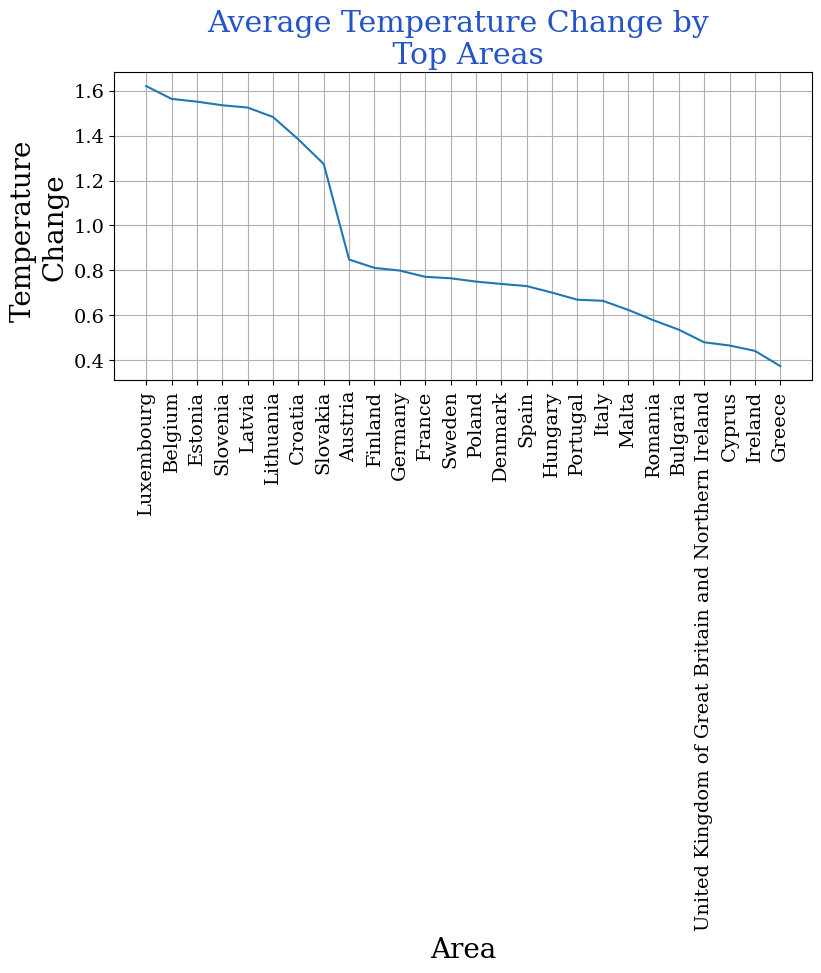

,Average Temperature Change
Area,
Luxembourg,1.620576
Belgium,1.563750
Estonia,1.551352
Slovenia,1.535167
Latvia,1.525042
Lithuania,1.482896
Croatia,1.382987
Slovakia,1.273586
Austria,0.848000


In [23]:
AreaUn=TmpChgDf['Area'].unique()
AreaTmmn=[]
for Area in AreaUn:
    Areadf=TmpChgDf[TmpChgDf['Area']==Area].reset_index(drop=True)
    AreaTmmn.append(Areadf['Value'].mean())
AreaMnDf=pandas.DataFrame({
    "Area":AreaUn,
    "Average Temperature Change":AreaTmmn
})
AreaMnDfT20=AreaMnDf.sort_values(by="Average Temperature Change",ascending=False)
AreaMnDfT20=AreaMnDfT20.iloc[:30].set_index('Area')
pltmp.figure(figsize=(9,4))
pltmp.plot(AreaMnDfT20.index,AreaMnDfT20["Average Temperature Change"])
pltmp.title("Average Temperature Change by \n Top Areas")
pltmp.xlabel("Area")
pltmp.ylabel("Temperature \nChange")
pltmp.xticks(rotation=90)
pltmp.grid()
pltmp.show()
AreaMnDfT20

In [24]:
DummyMnDf=pandas.get_dummies(TmpChgDf['Months'],dtype=int)
DummyMnDf

,April,August,December,February,January,July,June,March,May,November,October,September
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
16471,0,0,1,0,0,0,0,0,0,0,0,0
16472,0,0,1,0,0,0,0,0,0,0,0,0
16473,0,0,1,0,0,0,0,0,0,0,0,0
16474,0,0,1,0,0,0,0,0,0,0,0,0


In [25]:
TmpChgDf1 = pandas.concat([TmpChgDf, DummyMnDf], axis=1)
TmpChgDf1.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Months Code,Months,Year Code,Year,...,December,February,January,July,June,March,May,November,October,September
0,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,January,1961,1961,...,0,0,1,0,0,0,0,0,0,0
1,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,January,1962,1962,...,0,0,1,0,0,0,0,0,0,0
2,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,January,1963,1963,...,0,0,1,0,0,0,0,0,0,0
3,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,January,1964,1964,...,0,0,1,0,0,0,0,0,0,0
4,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,January,1965,1965,...,0,0,1,0,0,0,0,0,0,0


In [26]:
DummyFDDf=pandas.get_dummies(TmpChgDf1['Flag Description'],dtype=int)
TmpChgDf2 = pandas.concat([TmpChgDf1, DummyFDDf], axis=1)
TmpChgDf2.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Months Code,Months,Year Code,Year,...,February,January,July,June,March,May,November,October,September,Estimated value
0,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,January,1961,1961,...,0,1,0,0,0,0,0,0,0,1
1,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,January,1962,1962,...,0,1,0,0,0,0,0,0,0,1
2,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,January,1963,1963,...,0,1,0,0,0,0,0,0,0,1
3,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,January,1964,1964,...,0,1,0,0,0,0,0,0,0,1
4,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,January,1965,1965,...,0,1,0,0,0,0,0,0,0,1


In [27]:
mnun=TmpChgDf2['Months'].unique()
yrun=TmpChgDf2['Year'].unique()
dtsall=[]
for y in yrun:
    for m in mnun:
        dtv=0
        df=TmpChgDf2[(TmpChgDf2['Months']==m)&(TmpChgDf2['Year']==y)].reset_index(drop=True)
        for d in range(len(df)):
            dtv+=1
            dtsall.append(dtv)
try:
    TmpChgDf2=TmpChgDf2.drop('Day',axis=1)
    TmpChgDf2.insert(7,'Day',dtsall)
except:
    TmpChgDf2.insert(7,'Day',dtsall)
MonthV={'January':'1', 'February':'2', 'March':'3', 'April':'4', 'May':'5', 'June':'6', 'July':'7','August':'8', 'September':'9', 'October':'10', 'November':'11', 'December':'12'}
MnAct=TmpChgDf2['Months']
TmpChgDf2=TmpChgDf2.replace(MonthV)
TmpChgDf2   

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Months Code,Day,Months,Year Code,...,February,January,July,June,March,May,November,October,September,Estimated value
0,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,1,1,1961,...,0,1,0,0,0,0,0,0,0,1
1,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,2,1,1962,...,0,1,0,0,0,0,0,0,0,1
2,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,3,1,1963,...,0,1,0,0,0,0,0,0,0,1
3,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,4,1,1964,...,0,1,0,0,0,0,0,0,0,1
4,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,5,1,1965,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16471,ET,Temperature change on land,826,United Kingdom of Great Britain and Northern I...,7271,Temperature change,7012,22,12,2019,...,0,0,0,0,0,0,0,0,0,1
16472,ET,Temperature change on land,826,United Kingdom of Great Britain and Northern I...,7271,Temperature change,7012,23,12,2020,...,0,0,0,0,0,0,0,0,0,1
16473,ET,Temperature change on land,826,United Kingdom of Great Britain and Northern I...,7271,Temperature change,7012,24,12,2021,...,0,0,0,0,0,0,0,0,0,1
16474,ET,Temperature change on land,826,United Kingdom of Great Britain and Northern I...,7271,Temperature change,7012,25,12,2022,...,0,0,0,0,0,0,0,0,0,1


In [28]:
dt_list=TmpChgDf2['Day']
mn_list=TmpChgDf2['Months']
yr_list=TmpChgDf2['Year']
dateformat=[]
for yd in range(len(dt_list)):
    dateformat.append('{}'.format(dt_list[yd])+'-{}'.format(mn_list[yd])+'-{}'.format(yr_list[yd]))
try:
    TmpChgDf2=TmpChgDf2.drop('Date',axis=1)
    TmpChgDf2.insert(7,'Date',dateformat)
except:
    TmpChgDf2.insert(7,'Date',dateformat)
TmpChgDf2

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Months Code,Date,Day,Months,...,February,January,July,June,March,May,November,October,September,Estimated value
0,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,1-1-1961,1,1,...,0,1,0,0,0,0,0,0,0,1
1,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,2-1-1962,2,1,...,0,1,0,0,0,0,0,0,0,1
2,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,3-1-1963,3,1,...,0,1,0,0,0,0,0,0,0,1
3,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,4-1-1964,4,1,...,0,1,0,0,0,0,0,0,0,1
4,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,5-1-1965,5,1,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16471,ET,Temperature change on land,826,United Kingdom of Great Britain and Northern I...,7271,Temperature change,7012,22-12-2019,22,12,...,0,0,0,0,0,0,0,0,0,1
16472,ET,Temperature change on land,826,United Kingdom of Great Britain and Northern I...,7271,Temperature change,7012,23-12-2020,23,12,...,0,0,0,0,0,0,0,0,0,1
16473,ET,Temperature change on land,826,United Kingdom of Great Britain and Northern I...,7271,Temperature change,7012,24-12-2021,24,12,...,0,0,0,0,0,0,0,0,0,1
16474,ET,Temperature change on land,826,United Kingdom of Great Britain and Northern I...,7271,Temperature change,7012,25-12-2022,25,12,...,0,0,0,0,0,0,0,0,0,1


In [29]:
TmpChgDf2['Value_Mean']=TmpChgDf2.Value.rolling(3, win_type ='triang').sum().fillna(TmpChgDf2.Value.rolling(3, win_type ='triang').sum().mean()).tolist()
TmpChgDf2['Value_Median']=TmpChgDf2.Value.rolling(3, win_type ='triang').sum().fillna(TmpChgDf2.Value.rolling(3, win_type ='triang').sum().median()).tolist()
TmpChgDf2['Value_Std']=TmpChgDf2.Value.rolling(3, win_type ='triang').sum().fillna(TmpChgDf2.Value.rolling(3, win_type ='triang').sum().std()).tolist()
TmpChgDf2.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Months Code,Date,Day,Months,...,June,March,May,November,October,September,Estimated value,Value_Mean,Value_Median,Value_Std
0,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,1-1-1961,1,1,...,0,0,0,0,0,0,1,1.595001,1.52025,2.464977
1,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,2-1-1962,2,1,...,0,0,0,0,0,0,1,1.595001,1.52025,2.464977
2,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,3-1-1963,3,1,...,0,0,0,0,0,0,1,-1.591000,-1.59100,-1.591000
3,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,4-1-1964,4,1,...,0,0,0,0,0,0,1,-5.973500,-5.97350,-5.973500
4,ET,Temperature change on land,40,Austria,7271,Temperature change,7001,5-1-1965,5,1,...,0,0,0,0,0,0,1,-4.979000,-4.97900,-4.979000


In [32]:
def DataEnc(tcn):
    tcn1=tcn.copy()
    print("Feature Types Before Encoding")
    print(tcn1.info())
    obtcn=tcn1.dtypes[tcn1.dtypes=='object'].index.tolist()
    for l in obtcn:
        tcn1[l]=tcn1[l].replace(tcn1[l].unique(),[x for x in range(len(tcn1[l].unique()))]) 
    print("Feature Types After Encoding")
    print(tcn1.info())
    return tcn1
TmpChgDf2_encoded=DataEnc(TmpChgDf2)
TmpChgDf2_encoded.head()

Feature Types Before Encoding
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16476 entries, 0 to 16475
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Domain Code       16476 non-null  object 
 1   Domain            16476 non-null  object 
 2   Area Code (M49)   16476 non-null  int64  
 3   Area              16476 non-null  object 
 4   Element Code      16476 non-null  int64  
 5   Element           16476 non-null  object 
 6   Months Code       16476 non-null  int64  
 7   Date              16476 non-null  object 
 8   Day               16476 non-null  int64  
 9   Months            16476 non-null  object 
 10  Year Code         16476 non-null  int64  
 11  Year              16476 non-null  int64  
 12  Unit              16476 non-null  object 
 13  Value             16476 non-null  float64
 14  Flag              16476 non-null  object 
 15  Flag Description  16476 non-null  object 
 16  April     

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Months Code,Date,Day,Months,...,June,March,May,November,October,September,Estimated value,Value_Mean,Value_Median,Value_Std
0,0,0,40,0,7271,0,7001,0,1,0,...,0,0,0,0,0,0,1,1.595001,1.52025,2.464977
1,0,0,40,0,7271,0,7001,1,2,0,...,0,0,0,0,0,0,1,1.595001,1.52025,2.464977
2,0,0,40,0,7271,0,7001,2,3,0,...,0,0,0,0,0,0,1,-1.591000,-1.59100,-1.591000
3,0,0,40,0,7271,0,7001,3,4,0,...,0,0,0,0,0,0,1,-5.973500,-5.97350,-5.973500
4,0,0,40,0,7271,0,7001,4,5,0,...,0,0,0,0,0,0,1,-4.979000,-4.97900,-4.979000


[0.9949041  0.00495104]


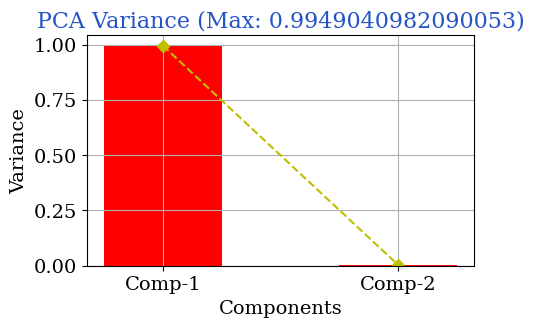

[0.17392376 0.13806299]


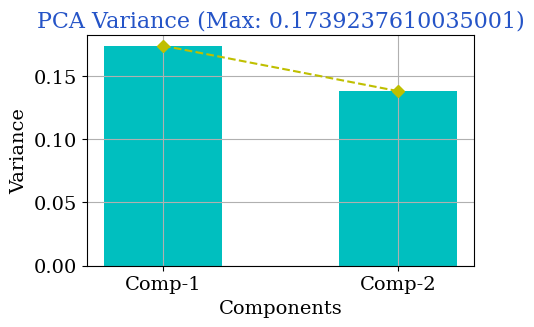

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Months Code,Date,Day,Months,...,March,May,November,October,September,Estimated value,Value_Mean,Value_Median,Value_Std,Value
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.501164,0.498334,0.534104,-0.807
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000120,0.04,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.501164,0.498334,0.534104,1.345
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000240,0.08,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.380535,0.380535,0.380535,-5.065
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000361,0.12,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.214603,0.214603,0.214603,-3.162
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000481,0.16,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.252258,0.252258,0.252258,1.431
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000601,0.20,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.394279,0.394279,0.394279,-2.156
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000721,0.24,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.391553,0.391553,0.391553,0.281
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000841,0.28,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.390076,0.390076,0.390076,-1.084
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000962,0.32,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.406698,0.406698,0.406698,0.087
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001082,0.36,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.424569,0.424569,0.424569,0.054


In [36]:
def OutLrFunc(tcn,v1):
    dfarr=numpy.array(tcn.iloc[:,:-1])
    tcnpca = decomposition.PCA(n_components=2)
    tcnpca.fit(dfarr)
    vrexp=tcnpca.explained_variance_ratio_
    valm=max(vrexp.tolist())
    print(vrexp)
    cmp_tcnpca=["Comp-{}".format(i+1) for i in range(len(vrexp.tolist()))]
    xlb,ylb="Components","Variance"
    pltmp.figure(figsize=(5,3))
    valml="%.3f" % valm
    pltmp.title("PCA Variance (Max: {})".format(max(vrexp.tolist())),fontsize=16)
    pltmp.bar(cmp_tcnpca,vrexp.tolist(),width=0.5,color=v1)
    pltmp.plot(vrexp.tolist(),"--yD")
    pltmp.xlabel(xlb,fontsize=14)
    pltmp.ylabel(ylb,fontsize=14)
    pltmp.grid()
    pltmp.show()
    return vrexp
def DataScale(tcn):
    SCLMM = preprocessing.MinMaxScaler()
    tcnscl=SCLMM.fit_transform(tcn)
    return tcnscl


trmvar=[]
trmvar.append(OutLrFunc(TmpChgDf2_encoded.drop(['Value'],axis=1),"r"))

stattmp=[]
for vr in trmvar:
    for v in vr:
        if v>0.8:
            stattmp.append(True)
if len(stattmp)==1 and True in stattmp:
    TmpChgDfNorm=DataScale(TmpChgDf2_encoded.drop(['Value'],axis=1))
TmpChgDfNorm=pandas.DataFrame(TmpChgDfNorm,columns=TmpChgDf2_encoded.drop(['Value'],axis=1).columns.tolist())
TmpChgDfNorm['Value']=TmpChgDf2_encoded['Value'].tolist()
OutLrFunc(TmpChgDfNorm.drop('Value',axis=1),"c")
TmpChgDfNorm.head(10)

In [39]:
font = {'family' : 'serif',
        'size'   : 14}
matplotlib.rc('font', **font)

In [57]:
def FetCorr(tcn):
    valcorr=tcn.corr()['Value']
    crdata=pandas.DataFrame({"Feature":valcorr.index,"Coeff":valcorr.tolist()})
    crdata=crdata.fillna(0)
    print(".................................................")
    print("Correlation Values of Features Before Filtering")
    print(".................................................")
    display(HTML(crdata.to_html()))
    crdata1=crdata[(crdata['Coeff']>0.02)|((crdata['Coeff']<-0.02))]
    print(".................................................")
    print("Correlation Values of Features After Filtering")
    print(".................................................")
    display(HTML(crdata1.to_html()))
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("       Total Features Selected Using Correlation: {}".format(len(crdata1['Feature'].tolist())))
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("Selected Features Using Correlation: ")
    print(*crdata1['Feature'].tolist(), sep="\n")
    return crdata1['Feature'].tolist()

In [58]:
def FetEnsm(tcn):
    Xtcn=tcn.drop([tcn.columns.tolist()[-1]],axis=1)
    Ytcn=tcn[tcn.columns.tolist()[-1]]
    nmft=Xtcn.columns.tolist()
    rfr = ensemble.RandomForestRegressor(random_state=0)
    rfr.fit(Xtcn, Ytcn)
    rfrimp = rfr.feature_importances_
    rfrdata=pandas.DataFrame({"Feature":nmft,"Importance":rfrimp})
    rfrdata1=rfrdata[rfrdata['Importance']>0.002]
    pltmp.figure(figsize=(7,3))
    pltmp.bar(rfrdata1['Feature'],rfrdata1['Importance'])
    pltmp.title("Feature Importance",fontsize=20,color="b")
    pltmp.xlabel("Features",fontsize=17,color="b")
    pltmp.ylabel("Importance",fontsize=17,color="b")
    pltmp.xticks(rotation=90)
    pltmp.grid()
    pltmp.show()
    display(HTML(rfrdata1.to_html()))
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("       Total Features Selected Using Ensemble: {}".format(len(rfrdata1)))
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("Selected Features Using Ensemble: ")
    print(*rfrdata1['Feature'].tolist(), sep="\n")
    return rfrdata1['Feature'].tolist()

.................................................
Correlation Values of Features Before Filtering
.................................................


,Feature,Coeff
0,Domain Code,0.000000
1,Domain,0.000000
2,Area Code (M49),-0.008816
3,Area,-0.008648
4,Element Code,0.000000
5,Element,0.000000
6,Months Code,-0.080677
7,Date,-0.028639
8,Day,0.003198
9,Months,-0.080677


.................................................
Correlation Values of Features After Filtering
.................................................


,Feature,Coeff
6,Months Code,-0.080677
7,Date,-0.028639
9,Months,-0.080677
10,Year Code,0.386381
11,Year,0.386381
16,August,0.030751
17,December,-0.047342
18,February,0.030187
19,January,0.033017
20,July,0.029240


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
       Total Features Selected Using Correlation: 18
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Selected Features Using Correlation: 
Months Code
Date
Months
Year Code
Year
August
December
February
January
July
March
November
October
September
Value_Mean
Value_Median
Value_Std
Value


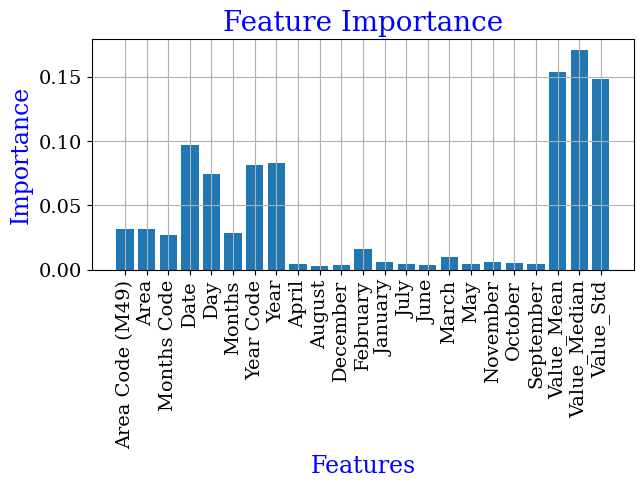

,Feature,Importance
2,Area Code (M49),0.031328
3,Area,0.031557
6,Months Code,0.027244
7,Date,0.097082
8,Day,0.074559
9,Months,0.028604
10,Year Code,0.081701
11,Year,0.082971
15,April,0.004178
16,August,0.003012


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
       Total Features Selected Using Ensemble: 23
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Selected Features Using Ensemble: 
Area Code (M49)
Area
Months Code
Date
Day
Months
Year Code
Year
April
August
December
February
January
July
June
March
May
November
October
September
Value_Mean
Value_Median
Value_Std


In [59]:
HybFet=[]  
ft1=FetCorr(TmpChgDfNorm) 
ft2=FetEnsm(TmpChgDfNorm) 
for f in ft1:   
    if f in ft2:   
        HybFet.append(f) 

In [60]:
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("       Total Features Selected Using Hybrid Approach: {}".format(len(HybFet)))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Selected Features Using Hybrid Approach: ")
print(*HybFet, sep="\n")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
       Total Features Selected Using Hybrid Approach: 17
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Selected Features Using Hybrid Approach: 
Months Code
Date
Months
Year Code
Year
August
December
February
January
July
March
November
October
September
Value_Mean
Value_Median
Value_Std


In [61]:
PredData=TmpChgDfNorm[HybFet]
TarData=TmpChgDfNorm['Value']
PredData.head()

,Months Code,Date,Months,Year Code,Year,August,December,February,January,July,March,November,October,September,Value_Mean,Value_Median,Value_Std
0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.501164,0.498334,0.534104
1,0.0,0.000120,0.0,0.016129,0.016129,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.501164,0.498334,0.534104
2,0.0,0.000240,0.0,0.032258,0.032258,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.380535,0.380535,0.380535
3,0.0,0.000361,0.0,0.048387,0.048387,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.214603,0.214603,0.214603
4,0.0,0.000481,0.0,0.064516,0.064516,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.252258,0.252258,0.252258


In [62]:
TarData

0       -0.807
1        1.345
2       -5.065
3       -3.162
4        1.431
         ...  
16471    1.285
16472    0.652
16473    1.428
16474   -0.688
16475    1.843
Name: Value, Length: 16476, dtype: float64

In [81]:
def DataSegment(prd,tr):
    data=pandas.concat([prd,tr],axis=1)
    Train=utils.resample(data,replace = True, n_samples = int(len(data)*0.75), random_state = 10).reset_index(drop=True)
    Test=utils.resample(data,replace = True, n_samples = int(len(data)*0.25), random_state = 10).reset_index(drop=True)
    XTrainTmp,XTestTmp,yTrainTmp,YTestTmp=Train[HybFet],Test[HybFet],Train['Value'],Test['Value']
    return XTrainTmp,XTestTmp,yTrainTmp,YTestTmp

XTrainTmp,XTestTmp,yTrainTmp,YTestTmp=DataSegment(PredData,TarData)

In [85]:
RegressionTmp=[
    ensemble.RandomForestRegressor(),
    linear_model.SGDRegressor(),
    neural_network.MLPRegressor(),
    svm.LinearSVR(),
    tree.DecisionTreeRegressor()
]
NamesReg=[
    "Random Forest",
    "SGD Regression",
    "MLP Regression",
    "Support Vector Regression",
    "Decision Tree"
]

RegressionTuned=RegressionTmp.copy()
dirfiles=os.listdir(os.getcwd())
hyperm=[]
timetotune=[]
clfloaded=['RandomForestRegressor.sav','SGDRegressor.sav','MLPRegressor.sav','LinearSVR.sav','DecisionTreeRegressor.sav']
if 'RandomForestRegressor.sav' in dirfiles and 'LinearRegression.sav' in dirfiles and 'MLPRegressor.sav' in dirfiles and 'LinearSVR.sav' in dirfiles and 'DecisionTreeRegressor.sav' in dirfiles:
    rgsmd1=pickle.load(open(clfloaded[0], 'rb'))
    rgsmd2=pickle.load(open(clfloaded[1], 'rb'))
    rgsmd3=pickle.load(open(clfloaded[2], 'rb'))
    rgsmd4=pickle.load(open(clfloaded[3], 'rb'))
    rgsmd5=pickle.load(open(clfloaded[4], 'rb'))
    RegressionTuned=[rgsmd1,rgsmd2,rgsmd3,rgsmd4,rgsmd5]
    print(*RegressionTuned, sep="\n")
else:
    tunables=[
        [{"criterion":['squared_error', 'absolute_error'],"max_depth":[80,100]}],
        [{"tol":[0.01,0.001,0.0001,0.00001],'max_iter':[500,1000]}],
        [{"activation":['logistic', 'tanh', 'relu'],"solver":['sgd', 'adam']}],
        [{"tol":[0.01,0.001,0.0001,0.00001],'C':[0.2,0.4,0.6,0.8,1.0]}],
        [{"criterion":['squared_error', 'absolute_error'],"max_depth":[20,30,40]}]        
    ]

    for ce in range(len(RegressionTuned)):
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print("\tTuning {} Model\n".format(NamesReg[ce]))
        t1 = datetime.datetime.now() 
        RegsGS = model_selection.GridSearchCV(RegressionTuned[ce], tunables[ce], cv = 5, scoring='r2')
        RegsGS.fit(PredData, TarData)
        RegressionTuned[ce]=RegsGS.best_estimator_
        print("\tOptimum Parameters of {} => \n\t\t\t{}".format(NamesReg[ce],RegsGS.best_estimator_))
        t2 = datetime.datetime.now()
        delta = t2 - t1
        eta=delta.total_seconds()
        print("\tTime of Tuning: {} Seconds".format(eta))
        print("\n\tFine Tuning Done for => '{}'".format(NamesReg[ce]))
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        hyperm.append(RegsGS.best_estimator_)
        timetotune.append("%.2f" % eta)

    for ced in range(len(RegressionTuned)):
        pickle.dump(RegressionTuned[ced], open(clfloaded[ced], 'wb'))
    print(*RegressionTuned, sep="\n")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
	Tuning Random Forest Model

	Optimum Parameters of Random Forest => 
			RandomForestRegressor(max_depth=100)
	Time of Tuning: 2867.369267 Seconds

	Fine Tuning Done for => 'Random Forest'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
	Tuning SGD Regression Model

	Optimum Parameters of SGD Regression => 
			SGDRegressor(max_iter=500, tol=1e-05)
	Time of Tuning: 1.599456 Seconds

	Fine Tuning Done for => 'SGD Regression'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
	Tuning MLP Regression Model



C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Optimum Parameters of MLP Regression => 
			MLPRegressor(solver='sgd')
	Time of Tuning: 85.368112 Seconds

	Fine Tuning Done for => 'MLP Regression'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
	Tuning Support Vector Regression Model



C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


	Optimum Parameters of Support Vector Regression => 
			LinearSVR(C=0.6)
	Time of Tuning: 2.057858 Seconds

	Fine Tuning Done for => 'Support Vector Regression'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
	Tuning Decision Tree Model

	Optimum Parameters of Decision Tree => 
			DecisionTreeRegressor(max_depth=20)
	Time of Tuning: 84.405784 Seconds

	Fine Tuning Done for => 'Decision Tree'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RandomForestRegressor(max_depth=100)
SGDRegressor(max_iter=500, tol=1e-05)
MLPRegressor(solver='sgd')
LinearSVR(C=0.6)
DecisionTreeRegressor(max_depth=20)


In [88]:
if "Hyperparameter_Data.csv" not in os.listdir():
    DataHYP=pandas.DataFrame({"Models":NamesReg,"Hyperparameters":hyperm,"Time of Optimization":timetotune})
    DataHYP.to_csv("Hyperparameter_Data.csv")
else:
    DataHYP=pandas.read_csv("Hyperparameter_Data.csv")
    DataHYP=DataHYP.drop('Unnamed: 0',axis=1)
DataHYP

,Models,Hyperparameters,Time of Optimization
0,Random Forest,"(DecisionTreeRegressor(max_depth=100, max_feat...",2867.37
1,SGD Regression,"SGDRegressor(max_iter=500, tol=1e-05)",1.60
2,MLP Regression,MLPRegressor(solver='sgd'),85.37
3,Support Vector Regression,LinearSVR(C=0.6),2.06
4,Decision Tree,DecisionTreeRegressor(max_depth=20),84.41


Predicting Using Untuned Random Forest
Elasped Time: 8.031 Seconds
______________________________________
Predicting Using Untuned SGD Regression
Elasped Time: 0.034 Seconds
______________________________________
Predicting Using Untuned MLP Regression
Elasped Time: 2.698 Seconds
______________________________________
Predicting Using Untuned Support Vector Regression
Elasped Time: 0.031 Seconds
______________________________________
Predicting Using Untuned Decision Tree
Elasped Time: 0.109 Seconds
______________________________________


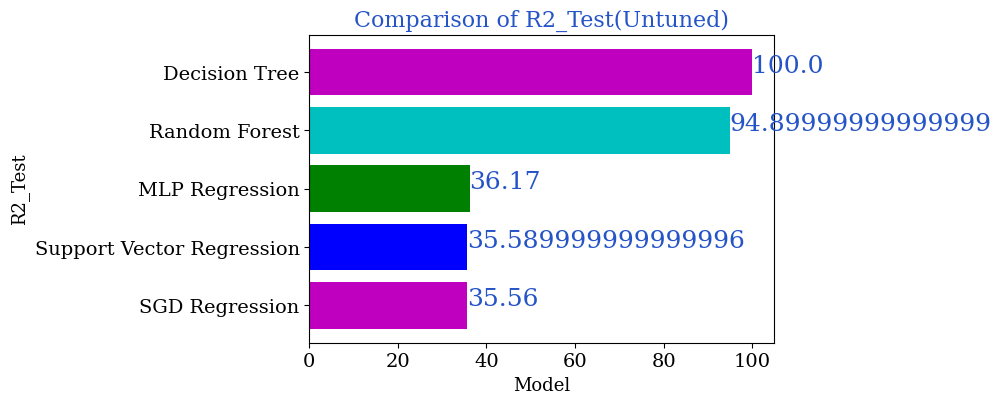

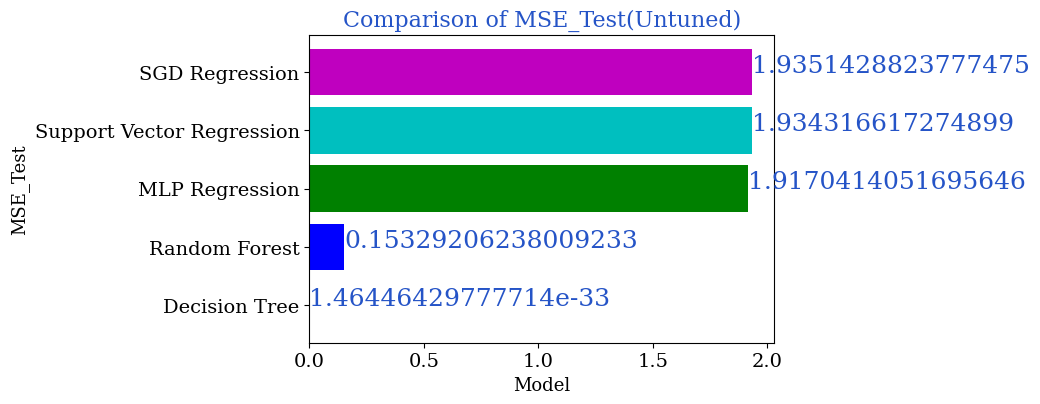

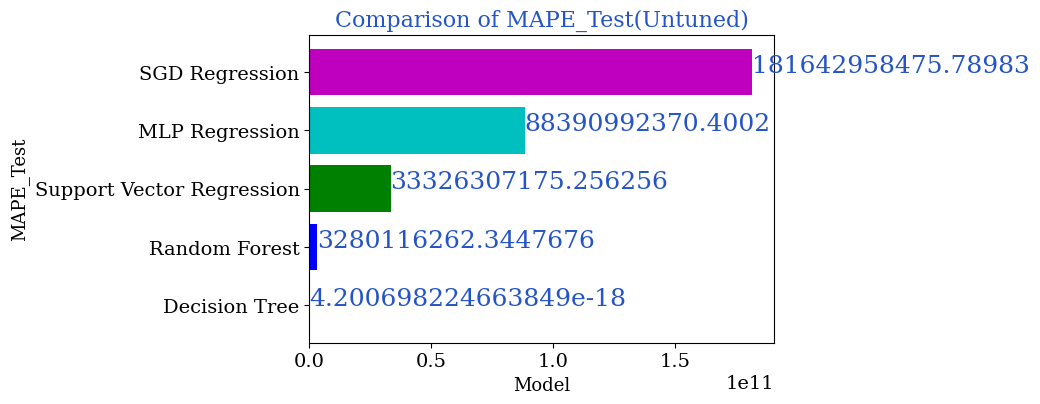

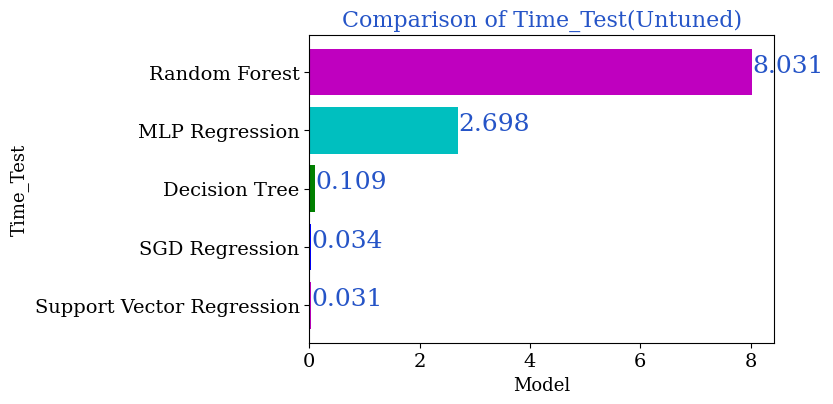

,Model,R2_Train,R2_Test,MSE_Test,MAPE_Test,Time_Test
0,Decision Tree,100.00,100.00,1.464464e-33,4.200698e-18,0.109
1,Random Forest,95.08,94.90,1.532921e-01,3.280116e+09,8.031
2,MLP Regression,35.13,36.17,1.917041e+00,8.839099e+10,2.698
3,Support Vector Regression,34.40,35.59,1.934317e+00,3.332631e+10,0.031
4,SGD Regression,34.29,35.56,1.935143e+00,1.816430e+11,0.034


In [91]:
RegressionTmp=[
    ensemble.RandomForestRegressor(),
    linear_model.SGDRegressor(),
    neural_network.MLPRegressor(),
    svm.LinearSVR(),
    tree.DecisionTreeRegressor()
      
]
NamesReg=[
    "Random Forest",
    "SGD Regression",
    "MLP Regression",
    "Support Vector Regression",
    "Decision Tree"
]

def TempChangePred(rgmd, XTrainData, XTestData, yTrainData, yTestData):
    RegTm=rgmd
    RegTm.fit(XTrainData, yTrainData)
    tmppredicted=RegTm.predict(XTestData)
    tmppredicted_tr=RegTm.predict(XTrainData)
    error_mse=metrics.mean_squared_error(yTestData,tmppredicted,squared=True)
    rscr=round(metrics.r2_score(yTestData,tmppredicted),4)*100
    rscr_train=round(metrics.r2_score(yTrainData,tmppredicted_tr),4)*100
    error_map=metrics.mean_absolute_percentage_error(yTestData,tmppredicted)
    return rscr,rscr_train,error_mse,error_map

ListMetTmpChngUTnd=[[],[],[],[],[],[]]
for i in range(len(RegressionTmp)):
    time1 = datetime.datetime.now() 
    print("Predicting Using Untuned {}".format(NamesReg[i]))
    PrdCv=TempChangePred(RegressionTmp[i], XTrainTmp, XTestTmp, yTrainTmp, YTestTmp)
    ListMetTmpChngUTnd[0].append(PrdCv[0])
    ListMetTmpChngUTnd[1].append(PrdCv[1])
    ListMetTmpChngUTnd[2].append(PrdCv[2])
    ListMetTmpChngUTnd[3].append(PrdCv[3])
    time2 = datetime.datetime.now()
    timeel = time2-time1
    timereq=timeel.total_seconds()
    ListMetTmpChngUTnd[4].append(round(timereq,3))
    print("Elasped Time: {} Seconds".format(round(timereq,3)))
    print("______________________________________")

DataTmpChgRes=pandas.DataFrame({
    "Model":NamesReg,
    "R2_Train":ListMetTmpChngUTnd[1],
    "R2_Test":ListMetTmpChngUTnd[0],
    "MSE_Test":ListMetTmpChngUTnd[2],
    "MAPE_Test":ListMetTmpChngUTnd[3],
    "Time_Test":ListMetTmpChngUTnd[4]
})


clnf_all_lst=DataTmpChgRes.columns.tolist()[2:]
for i in clnf_all_lst:
    DataTmpChgRes=DataTmpChgRes.sort_values(by=i,ascending=True)
    pltmp.figure(figsize=(6,4))
    pltmp.title("Comparison of {}(Untuned)".format(i),fontsize=16)
    pltmp.barh(DataTmpChgRes['Model'],DataTmpChgRes[i],color=["m","b","g","c"])
    pltmp.xlabel("Model",fontsize=13)
    pltmp.ylabel("{}".format(i),fontsize=13)
    for gid, vlgl in enumerate(DataTmpChgRes[i]):
        pltmp.text(vlgl, gid, str(vlgl))
    pltmp.show()
DataTmpChgRes=DataTmpChgRes.sort_values(by='R2_Test',ascending=False).reset_index(drop=True)
DataTmpChgRes.to_csv("Result_TempChange_Untuned.csv")
DataTmpChgRes

Predicting Using Untuned Random Forest
Elasped Time: 8.07 Seconds
______________________________________
Predicting Using Untuned SGD Regression
Elasped Time: 0.044 Seconds
______________________________________
Predicting Using Untuned MLP Regression
Elasped Time: 2.62 Seconds
______________________________________
Predicting Using Untuned Support Vector Regression
Elasped Time: 0.024 Seconds
______________________________________
Predicting Using Untuned Decision Tree
Elasped Time: 0.097 Seconds
______________________________________


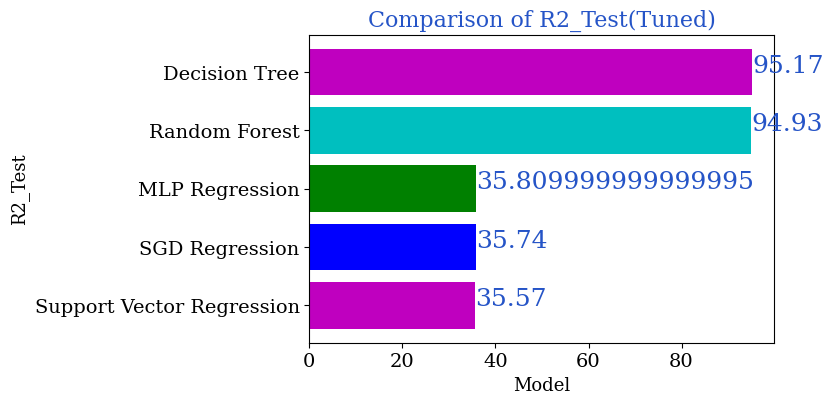

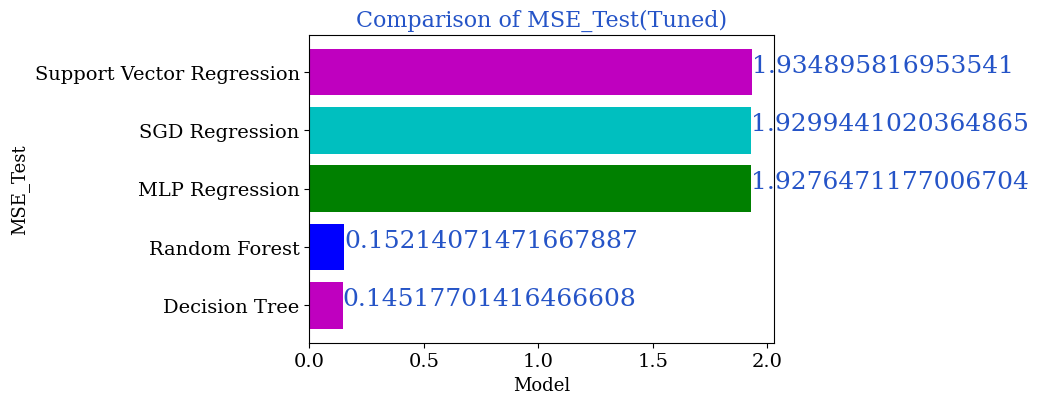

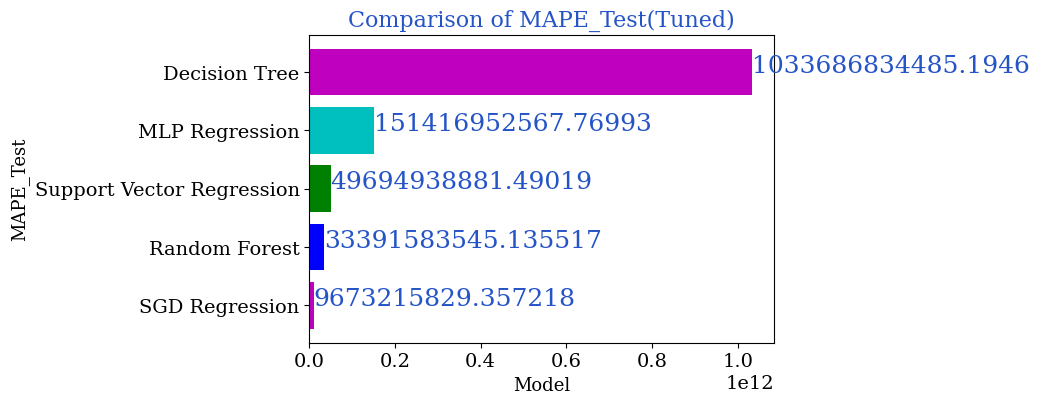

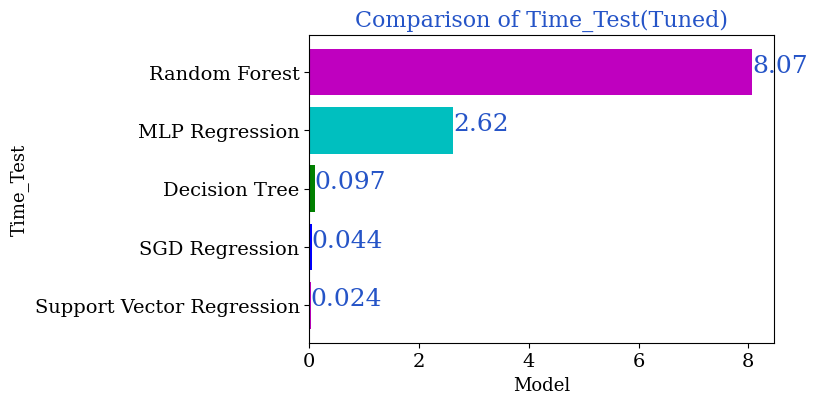

,Model,R2_Train,R2_Test,MSE_Test,MAPE_Test,Time_Test
0,Decision Tree,94.62,95.17,0.145177,1.033687e+12,0.097
1,Random Forest,95.10,94.93,0.152141,3.339158e+10,8.070
2,MLP Regression,34.60,35.81,1.927647,1.514170e+11,2.620
3,SGD Regression,34.41,35.74,1.929944,9.673216e+09,0.044
4,Support Vector Regression,34.40,35.57,1.934896,4.969494e+10,0.024


In [92]:
def TempChangePred(rgmd, XTrainData, XTestData, yTrainData, yTestData):
    RegTm=rgmd
    RegTm.fit(XTrainData, yTrainData)
    tmppredicted=RegTm.predict(XTestData)
    tmppredicted_tr=RegTm.predict(XTrainData)
    error_mse=metrics.mean_squared_error(yTestData,tmppredicted,squared=True)
    rscr=round(metrics.r2_score(yTestData,tmppredicted),4)*100
    rscr_train=round(metrics.r2_score(yTrainData,tmppredicted_tr),4)*100
    error_map=metrics.mean_absolute_percentage_error(yTestData,tmppredicted)
    return rscr,rscr_train,error_mse,error_map

ListMetTmpChngTnd=[[],[],[],[],[],[]]
for i in range(len(RegressionTuned)):
    time1 = datetime.datetime.now() 
    print("Predicting Using Untuned {}".format(NamesReg[i]))
    PrdCv=TempChangePred(RegressionTuned[i], XTrainTmp, XTestTmp, yTrainTmp, YTestTmp)
    ListMetTmpChngTnd[0].append(PrdCv[0])
    ListMetTmpChngTnd[1].append(PrdCv[1])
    ListMetTmpChngTnd[2].append(PrdCv[2])
    ListMetTmpChngTnd[3].append(PrdCv[3])
    time2 = datetime.datetime.now()
    timeel = time2-time1
    timereq=timeel.total_seconds()
    ListMetTmpChngTnd[4].append(round(timereq,3))
    print("Elasped Time: {} Seconds".format(round(timereq,3)))
    print("______________________________________")

DataTmpChgResTuned=pandas.DataFrame({
    "Model":NamesReg,
    "R2_Train":ListMetTmpChngTnd[1],
    "R2_Test":ListMetTmpChngTnd[0],
    "MSE_Test":ListMetTmpChngTnd[2],
    "MAPE_Test":ListMetTmpChngTnd[3],
    "Time_Test":ListMetTmpChngTnd[4]
})


clnf_all_lst=DataTmpChgResTuned.columns.tolist()[2:]
for i in clnf_all_lst:
    DataTmpChgResTuned=DataTmpChgResTuned.sort_values(by=i,ascending=True)
    pltmp.figure(figsize=(6,4))
    pltmp.title("Comparison of {}(Tuned)".format(i),fontsize=16)
    pltmp.barh(DataTmpChgResTuned['Model'],DataTmpChgResTuned[i],color=["m","b","g","c"])
    pltmp.xlabel("Model",fontsize=13)
    pltmp.ylabel("{}".format(i),fontsize=13)
    for gid, vlgl in enumerate(DataTmpChgResTuned[i]):
        pltmp.text(vlgl, gid, str(vlgl))
    pltmp.show()
DataTmpChgResTuned=DataTmpChgResTuned.sort_values(by='R2_Test',ascending=False).reset_index(drop=True)
DataTmpChgResTuned.to_csv("Result_TempChange_Tuned.csv")
DataTmpChgResTuned

In [93]:
print(*RegressionTmp, sep="\n")

RandomForestRegressor()
SGDRegressor()
MLPRegressor()
LinearSVR()
DecisionTreeRegressor()


In [94]:
print(*RegressionTuned, sep="\n")

RandomForestRegressor(max_depth=100)
SGDRegressor(max_iter=500, tol=1e-05)
MLPRegressor(solver='sgd')
LinearSVR(C=0.6)
DecisionTreeRegressor(max_depth=20)


In [126]:
TempForecast=TmpChgDf2[['Date','Value']]
TempForecast.columns=['Date','TempChange']
TempForecast=TempForecast.sort_values(by='Date').reset_index(drop=True)
TempForecast.head(10)

,Date,TempChange
0,1-1-1961,-0.807
1,1-1-1961,0.140
2,1-1-1961,0.033
3,1-1-1963,-4.397
4,1-1-1965,1.329
5,1-1-1967,0.234
6,1-1-1967,-4.350
7,1-1-1967,-0.367
8,1-1-1967,-0.931
9,1-1-1967,1.192


In [136]:
#TempForecast.groupby('Date')['TempChange']
RearrangeData=TempForecast.groupby(["Date"]).agg({"TempChange": [numpy.mean]}).sort_values(by=("TempChange","mean"),ascending=False)
RearrangeData['Date']=RearrangeData.index
RearrangeData=RearrangeData.reset_index(drop=True)
RearrangeData=RearrangeData.sort_values(by='Date').reset_index(drop=True)
RearrangeData.columns=['TempChange','Date']
RearrangeData

MultiIndex([('TempChange', 'mean'),
            (      'Date',     '')],
           )


,TempChange,Date
0,-0.211333,1-1-1961
1,-4.397000,1-1-1963
2,1.329000,1-1-1965
3,-0.844400,1-1-1967
4,2.605000,1-1-1971
...,...,...
8316,0.895250,9-9-2017
8317,1.921000,9-9-2019
8318,2.834000,9-9-2020
8319,0.511500,9-9-2021


<Axes: >

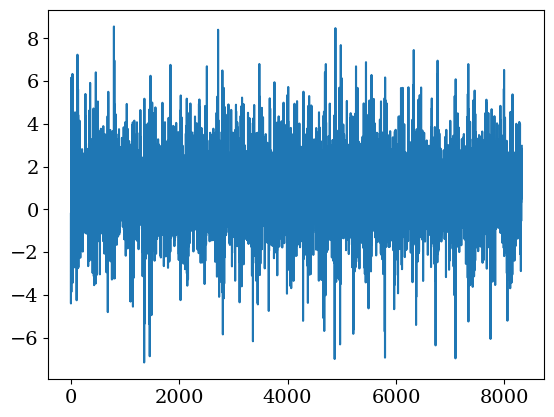

In [139]:
RearrangeData['TempChange'].plot(kind='line')

In [137]:
print("Observations of Dickey-fuller test")
testadf = adfuller(RearrangeData['TempChange'],autolag='AIC')
outadf=pandas.Series(testadf[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in testadf[4].items():
    outadf['critical value (%s)'%key]= value
print(outadf)
testval=outadf[0]
critval=outadf[4]
if testval<critval:
    print("\nData is Stationary")
else:
    print("\nData is not Stationary")

Observations of Dickey-fuller test
Test Statistic                -1.489165e+01
p-value                        1.554059e-27
#lags used                     3.500000e+01
number of observations used    8.285000e+03
critical value (1%)           -3.431140e+00
critical value (5%)           -2.861889e+00
critical value (10%)          -2.566956e+00
dtype: float64

Data is Stationary


In [118]:
def CalcVal(dataset, interval=1):
    df_vals = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        df_vals.append(value) 
    diffval=numpy.array(df_vals)
    return diffval
def CalcInv(hstval, hist_y, interval=1):
    return hist_y + hstval[-interval]

In [151]:
FrcstFet='TempChange'
DataForecast=RearrangeData.copy()
DataForecast['Date'] =  pandas.to_datetime(DataForecast.Date,format='%d-%m-%Y')
DataForecast.index = DataForecast['Date']
DataForecast = DataForecast.drop('Date',axis=1)
X = DataForecast[FrcstFet].values 
YrDays = 365 
ValDifference = CalcVal(X, YrDays)
ModelForecast = ARIMA(ValDifference, order=(7,0,1))
ModelForecast_fit = ModelForecast.fit()
lndf = len(ValDifference)
flag=True
while flag==True:
    try:
        dfp=int(input("Days to Forecast Cases: "))
        flag=False
    except:
        print("Please Enter Correct Input") 
        flag=True
endval = lndf + (dfp-1)
ValuePredicted = ModelForecast_fit.predict(start=lndf, end=endval)
HistPrices = [x for x in X]
TCFrcs=[]
day = 1
for yHistoryValue in ValuePredicted:
    inv_value = CalcInv(HistPrices, yHistoryValue, YrDays)  
    HistPrices.append(inv_value) 
    TCFrcs.append(inv_value)
    day += 1

Dates_Forecastable=[]  
for i in range(dfp): 
    Dates_Forecastable.append(DataForecast.index[-1]+datetime.timedelta(days=i))

Days to Forecast Cases: 365


In [152]:
TempChangeForecastData=pandas.DataFrame({"Date":Dates_Forecastable,"Forecasted Values":TCFrcs})
TempChangeForecastData.to_csv("Forecast_1_year_{}.csv")
dates=DataForecast.index.tolist()
TempChangeForecastData1=TempChangeForecastData.copy()
fore_date=TempChangeForecastData1.Date.tolist()
TempChangeForecastData1=TempChangeForecastData1.drop('Date',axis=1)
alldate=dates+fore_date
arimadf=pandas.DataFrame({"Date":alldate,"Forecast":HistPrices})
TempChangeForecastData2=TempChangeForecastData.copy()
TempChangeForecastData2=TempChangeForecastData2.drop('Date',axis=1)
TempChangeForecastData2.index=fore_date
TempChangeForecastData2

,Forecasted Values
2023-09-09,0.626193
2023-09-10,0.162569
2023-09-11,1.674190
2023-09-12,-1.602438
2023-09-13,0.672671
...,...
2024-09-03,0.892628
2024-09-04,1.918378
2024-09-05,2.831378
2024-09-06,0.508878


In [150]:
pltlygrp=go.Figure()
pltlygrp.add_trace(go.Scatter(x=RearrangeData['Date'], y=RearrangeData[FrcstFet], mode='lines',name="Actual Values"))
pltlygrp.add_trace(go.Scatter(x=TempChangeForecastData2.index, y=TempChangeForecastData2["Forecasted Values"], mode='lines',name="Forecasted".format(FrcstFet),))
pltlygrp.update_layout(title="Temperature Change Forecasting for ({})Days".format(dfp),xaxis_title="Date",yaxis_title=FrcstFet,legend=dict(x=0,y=1,traceorder="normal"),font=dict(size=12))
pltlygrp.show()

In [153]:
ModelForecast_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7956
Model:                 ARIMA(7, 0, 1)   Log Likelihood              -17469.613
Date:                Wed, 18 Dec 2024   AIC                          34959.225
Time:                        15:38:57   BIC                          35029.042
Sample:                             0   HQIC                         34983.129
                               - 7956                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.030     -0.089      0.929      -0.061       0.055
ar.L1         -0.1975      0.269     -0.735      0.462      -0.724       0.329
ar.L2          0.0644      0.025      2.589      0.010       0.016       0.113
ar.L3          0.0681      0.015      4.573      0.000       0.039       0.097
ar.L4          0.0071      0.018      0.388      0.698      -0.029       0.043
ar.L5          0.0324      0.011      2.945      0.003       0.011       0.054
ar.L6          0.0020      0.014      0.143      0.887      -0.026       0.030
ar.L7         -0.0369      0.011     -3.488      0.000      -0.058      -0.016
ma.L1          0.2823      0.269      1.050      0.293      -0.244       0.809
sigma2         4.7288      0.062     75.854      0.000       4.607       4.851
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               292.24
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.01
Prob(H) (two-sided):                  0.90   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""